# Setup

In [1]:
# Data wrangling
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.preprocessing import StandardScaler, PowerTransformer, OrdinalEncoder, OneHotEncoder

# Models
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Models Pipelines
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Model evaluation
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV

# Save model
import pickle

# Set output as pandas
from sklearn import set_config
set_config(transform_output="pandas")

In [2]:
## -- Functions - ##
def get_metrics(y_true, y_pred):
    dict_metrics = {
        'Accuracy': metrics.accuracy_score(y_true, y_pred),
        'Balanced Accuracy': metrics.balanced_accuracy_score(y_true, y_pred),
        'Recall': metrics.recall_score(y_true, y_pred),
        'Precison': metrics.precision_score(y_true, y_pred),
        'F1': metrics.f1_score(y_true, y_pred),
        'ROC_AUC': metrics.roc_auc_score(y_true, y_pred)
    }
    return dict_metrics

In [3]:
# Load data
df = pd.read_csv('../data/customer_churn.csv', index_col='CustomerID')

# Data Understanding

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 3668-QPYBK to 3186-AJIEK
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Latitude           7032 non-null   float64
 1   Longitude          7032 non-null   float64
 2   Gender             7032 non-null   object 
 3   Senior Citizen     7032 non-null   object 
 4   Partner            7032 non-null   object 
 5   Dependents         7032 non-null   object 
 6   Tenure Months      7032 non-null   int64  
 7   Phone Service      7032 non-null   object 
 8   Multiple Lines     7032 non-null   object 
 9   Internet Service   7032 non-null   object 
 10  Online Security    7032 non-null   object 
 11  Online Backup      7032 non-null   object 
 12  Device Protection  7032 non-null   object 
 13  Tech Support       7032 non-null   object 
 14  Streaming TV       7032 non-null   object 
 15  Streaming Movies   7032 non-null   object 
 16  Contract      

In [5]:
df.describe()

,Latitude,Longitude,Tenure Months,Monthly Charges,Total Charges,CLTV,Churn Value
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,36.283307,-119.799215,32.421786,64.798208,2283.300441,4401.445108,0.265785
std,2.456118,2.157588,24.545260,30.085974,2266.771362,1182.414266,0.441782
min,32.555828,-124.301372,1.000000,18.250000,18.800000,2003.000000,0.000000
25%,34.030915,-121.815412,9.000000,35.587500,401.450000,3469.750000,0.000000
50%,36.391777,-119.735410,29.000000,70.350000,1397.475000,4527.500000,0.000000
75%,38.227285,-118.043237,55.000000,89.862500,3794.737500,5381.000000,1.000000
max,41.962127,-114.192901,72.000000,118.750000,8684.800000,6500.000000,1.000000


In [6]:
df.duplicated().any()

False

In [7]:
df.isna().any()

Latitude             False
Longitude            False
Gender               False
Senior Citizen       False
Partner              False
Dependents           False
Tenure Months        False
Phone Service        False
Multiple Lines       False
Internet Service     False
Online Security      False
Online Backup        False
Device Protection    False
Tech Support         False
Streaming TV         False
Streaming Movies     False
Contract             False
Paperless Billing    False
Payment Method       False
Monthly Charges      False
Total Charges        False
CLTV                 False
Churn Value          False
dtype: bool

In [8]:
df['Churn Value'].value_counts()

0    5163
1    1869
Name: Churn Value, dtype: int64

In [9]:
df['Churn Value'].eq(0).sum() / df.shape[0]

0.7342150170648464

# Data Preparation

In [10]:
NUMERIC_FEATURES = [
    'Latitude',
    'Longitude',
    'Tenure Months',
    'Monthly Charges',
    'Total Charges',
    'CLTV'
]

CATEGORICAL_FEATURES = [
    'Gender',
    'Senior Citizen',
    'Partner',
    'Dependents',
    'Phone Service',
    'Multiple Lines',
    'Internet Service',
    'Online Security',
    'Online Backup',
    'Device Protection',
    'Tech Support',
    'Streaming TV',
    'Streaming Movies',
    'Contract',
    'Paperless Billing',
    'Payment Method'
]

FEATURES = NUMERIC_FEATURES + CATEGORICAL_FEATURES
TARGET = 'Churn Value'

In [11]:
X = df[FEATURES]
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, stratify=y, random_state=2023)

In [12]:
preprocessor = ColumnTransformer([
    ('scaler', StandardScaler(), NUMERIC_FEATURES),
    ('encoder', OneHotEncoder(drop='if_binary', sparse_output=False), CATEGORICAL_FEATURES),
])

In [14]:
preprocessor

ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                 ['Latitude', 'Longitude', 'Tenure Months',
                                  'Monthly Charges', 'Total Charges', 'CLTV']),
                                ('encoder',
                                 OneHotEncoder(drop='if_binary',
                                               sparse_output=False),
                                 ['Gender', 'Senior Citizen', 'Partner',
                                  'Dependents', 'Phone Service',
                                  'Multiple Lines', 'Internet Service',
                                  'Online Security', 'Online Backup',
                                  'Device Protection', 'Tech Support',
                                  'Streaming TV', 'Streaming Movies',
                                  'Contract', 'Paperless Billing',
                                  'Payment Method'])])

# Modeling & Evaluation

In [15]:
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DummyClassifier())
])

model_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['Latitude', 'Longitude',
                                                   'Tenure Months',
                                                   'Monthly Charges',
                                                   'Total Charges', 'CLTV']),
                                                 ('encoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse_output=False),
                                                  ['Gender', 'Senior Citizen',
                                                   'Partner', 'Dependents',
                                                   'Phone Service',
                                                   'Multiple Lines',
                                                   'Internet Service',
                                                   'Online Security',
                                                   'Online Backup',
                                                   'Device Protection',
                                                   'Tech Support',
                                                   'Streaming TV',
                                                   'Streaming Movies',
                                                   'Contract',
                                                   'Paperless Billing',
                                                   'Payment Method'])])),
                ('model', DummyClassifier())])

In [16]:
params = {
    'model': [
        LogisticRegressionCV(max_iter=1_000),
        RandomForestClassifier(random_state=2023),
        GradientBoostingClassifier(random_state=2023),
        LGBMClassifier(random_state=2023),
        DummyClassifier()
    ] 
}

grid = GridSearchCV(model_pipeline, params, cv=3, scoring='f1', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

df_grid_results = pd.DataFrame(grid.cv_results_).set_index('rank_test_score').sort_index()
df_grid_results.iloc[:,~df_grid_results.columns.str.contains('split|fit')]

Fitting 3 folds for each of 5 candidates, totalling 15 fits


,mean_score_time,std_score_time,param_model,params,mean_test_score,std_test_score
rank_test_score,,,,,,
1,0.054792,0.008409,LogisticRegressionCV(max_iter=1000),{'model': LogisticRegressionCV(max_iter=1000)},0.604340,0.014669
2,0.082442,0.041626,GradientBoostingClassifier(random_state=2023),{'model': GradientBoostingClassifier(random_st...,0.578001,0.015665
3,0.120089,0.032185,LGBMClassifier(random_state=2023),{'model': LGBMClassifier(random_state=2023)},0.556854,0.010455
4,0.450093,0.253623,RandomForestClassifier(random_state=2023),{'model': RandomForestClassifier(random_state=...,0.534526,0.016508
5,0.070679,0.004025,DummyClassifier(),{'model': DummyClassifier()},0.000000,0.000000


In [17]:
params = {
    'model': [
        LogisticRegressionCV(max_iter=1_000, class_weight='balanced'),
        RandomForestClassifier(random_state=2023, class_weight='balanced'),
        LGBMClassifier(is_unbalance=True, random_state=2023),
        DummyClassifier()
    ] 
}

grid = GridSearchCV(model_pipeline, params, cv=3, scoring='f1', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

df_grid_results = pd.DataFrame(grid.cv_results_).set_index('rank_test_score').sort_index()
df_grid_results.iloc[:,~df_grid_results.columns.str.contains('split|fit')]

Fitting 3 folds for each of 4 candidates, totalling 12 fits


,mean_score_time,std_score_time,param_model,params,mean_test_score,std_test_score
rank_test_score,,,,,,
1,0.106809,0.043697,"LogisticRegressionCV(class_weight='balanced', ...",{'model': LogisticRegressionCV(class_weight='b...,0.634029,0.006809
2,0.141972,0.054244,"LGBMClassifier(is_unbalance=True, random_state...","{'model': LGBMClassifier(is_unbalance=True, ra...",0.620445,0.018944
3,0.202684,0.042469,RandomForestClassifier(class_weight='balanced'...,{'model': RandomForestClassifier(class_weight=...,0.535552,0.025294
4,0.093899,0.059151,DummyClassifier(),{'model': DummyClassifier()},0.000000,0.000000


In [18]:
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(random_state=2023, max_iter=1_000))
])

params = {
    'preprocessor__scaler': [StandardScaler(), PowerTransformer()],
    'model__class_weight': ['balanced'],
    'model__C': [0.001, 0.01, 0.1],
}

grid = GridSearchCV(model_pipeline, params, cv=3, scoring='f1', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

df_grid_results = pd.DataFrame(grid.cv_results_).set_index('rank_test_score').sort_index()
df_grid_results.iloc[:,~df_grid_results.columns.str.contains('split|fit')]

Fitting 3 folds for each of 6 candidates, totalling 18 fits


,mean_score_time,std_score_time,param_model__C,param_model__class_weight,param_preprocessor__scaler,params,mean_test_score,std_test_score
rank_test_score,,,,,,,,
1,0.060339,0.007711,0.1,balanced,PowerTransformer(),"{'model__C': 0.1, 'model__class_weight': 'bala...",0.635714,0.007502
2,0.137409,0.064895,0.01,balanced,PowerTransformer(),"{'model__C': 0.01, 'model__class_weight': 'bal...",0.635652,0.014056
3,0.137405,0.085030,0.001,balanced,PowerTransformer(),"{'model__C': 0.001, 'model__class_weight': 'ba...",0.631422,0.016583
4,0.196910,0.052179,0.1,balanced,StandardScaler(),"{'model__C': 0.1, 'model__class_weight': 'bala...",0.630385,0.007294
5,0.063769,0.010201,0.01,balanced,StandardScaler(),"{'model__C': 0.01, 'model__class_weight': 'bal...",0.629136,0.014126
6,0.143732,0.132721,0.001,balanced,StandardScaler(),"{'model__C': 0.001, 'model__class_weight': 'ba...",0.623049,0.012870


In [19]:
tuned_model = grid.best_estimator_

y_pred = tuned_model.predict(X_test)
get_metrics(y_test, y_pred)

{'Accuracy': 0.7748815165876777,
 'Balanced Accuracy': 0.7909645576641362,
 'Recall': 0.8253119429590018,
 'Precison': 0.5511904761904762,
 'F1': 0.660956459671663,
 'ROC_AUC': 0.7909645576641362}

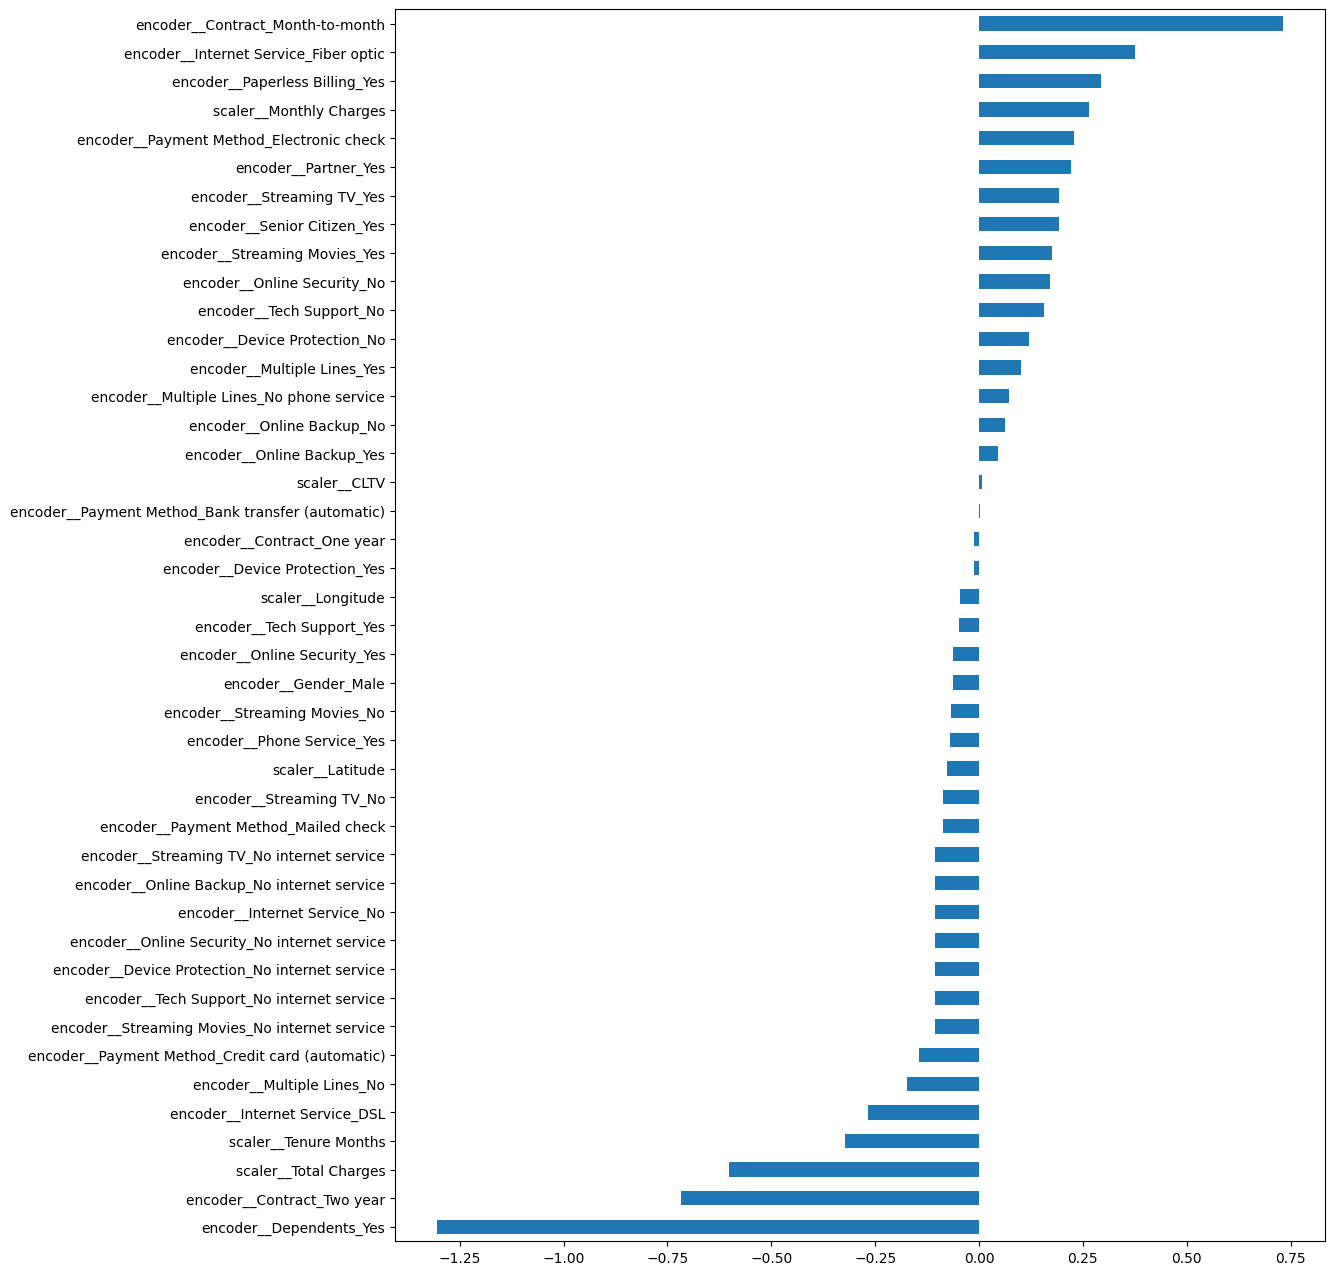

In [20]:
lr_model = tuned_model.named_steps['model']

coefs = pd.Series(
    data=lr_model.coef_[0],
    index=lr_model.feature_names_in_
)

plt.figure(figsize=(12,16))
coefs.sort_values().plot.barh()
plt.show()

# Deployment

In [21]:
with open('../models/model.pkl', 'wb') as model_file:
    pickle.dump(tuned_model, model_file)